In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats
import brian_model
import cluster_model
import brian_feature_engineering

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings

In [2]:
# MY PARTITIONS

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

## Let's take a moment to run some feature engineering....

In [3]:
X_train_scaled.columns

Index(['bathrooms', 'bedrooms', 'condition', 'sq_ft', 'full_baths', 'latitude',
       'longitude', 'lot_size', 'rooms', 'structure_value', 'tax_value',
       'year_assessed', 'land_value', 'tax_amount', 'age',
       'sq_ft_per_bathroom', 'sq_ft_per_bedroom', 'sq_ft_per_room',
       'has_half_bath', 'tax_rate', 'price_per_sq_ft', 'Los_Angeles', 'Orange',
       'Ventura'],
      dtype='object')

In [4]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
f_feature = brian_feature_engineering.select_kbest(X_train_scaled,y_train_scaled, 5)
f_feature

['bedrooms', 'condition', 'rooms', 'tax_amount', 'price_per_sq_ft']

In [5]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = brian_feature_engineering.select_rfe(X_train_scaled,y_train_scaled, 5)
rfe_feature

['condition',
 'lot_size',
 'structure_value',
 'sq_ft_per_bathroom',
 'price_per_sq_ft']

#  Modeling

### Scaling
I have done modeling on the scaled datasets

### Baseline
I will use MEAN as the baseline

### Features
I will use ____ as my kbest features; _______ as my rfe features
All the X_train_scaled, X_validate_scaled, etc. are scaled from X_train, etc.¶
All of the X_train_kbest, X_train_rfe, etc are derived from the scaled datasets

In [6]:
# This cell is running a function in my brian_model.py file
# It creates data sets for modeling based on the KBest and RFE features, respectively:
X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe \
= brian_model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [7]:
# 1. Predict logerror_pred_mean
# I create here new columns in the y_ data sets to hold the baseline value I am working with.
logerror_pred_mean = y_train_scaled.logerror.mean()
y_train_scaled['logerror_pred_mean'] = round(logerror_pred_mean, 5)
y_validate_scaled['logerror_pred_mean'] = round(logerror_pred_mean,5)
y_test_scaled['logerror_pred_mean'] = round(logerror_pred_mean,5)

In [8]:
y_train_scaled


,logerror,logerror_pred_mean
0,0.600496,0.60213
1,0.606472,0.60213
2,0.615869,0.60213
3,0.599217,0.60213
4,0.595534,0.60213
...,...,...
22156,0.593047,0.60213
22157,0.597474,0.60213
22158,0.601797,0.60213
22159,0.598466,0.60213


In [9]:
y_validate_scaled

,logerror,logerror_pred_mean
0,0.604279,0.60213
1,0.596996,0.60213
2,0.602457,0.60213
3,0.614430,0.60213
4,0.604331,0.60213
...,...,...
9493,0.610471,0.60213
9494,0.594626,0.60213
9495,0.596111,0.60213
9496,0.601831,0.60213


In [10]:
# 2. RMSE of logerror_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.logerror,
                                y_train_scaled.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.logerror_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.02 
Validate/Out-of-Sample:  0.02


In [11]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


In [12]:
metric_df = brian_model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

In [13]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018949,0.018989
2,OLS Regressor RFE,0.018944,0.018993
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018952,0.018989
6,glm_compound_rfe,0.018953,0.018993
7,quadratic_kbest,0.018929,0.018993
8,quadratic_rfe,0.018935,0.019002


# Next step: add clusters to X_train_scaled and X_etc_scaled

# Then: encode the clusters onto the df and rerun kbest and rfe

In [14]:
deal_cluster_df_train = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_validate = X_validate_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_test = X_test_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

In [15]:
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df_train)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df_train)

array([0, 4, 0, ..., 1, 3, 4], dtype=int32)

## Adding a cluster column to each pertinent df

In [16]:
X_train_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_train)
X_train_scaled['deal_cluster'] = np.where(X_train_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_train_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_train_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_train_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))



In [17]:
X_validate_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_validate)
X_validate_scaled['deal_cluster'] = np.where(X_validate_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_validate_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_validate_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_validate_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))



In [18]:
X_test_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_test)
X_test_scaled['deal_cluster'] = np.where(X_test_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_test_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_test_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_test_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))



## Encoding the clusters onto the respective dfs

In [43]:
# this is also in the cluster_model.py file

def encode_clusters(df,cluster):
    '''
    This is encoding the cluster column for later modelling; it drops the original column 
    once it has been encoded
    
    '''
    # ordinal encoder? sklearn.OrdinalEncoder

    # I had originally put the columns to be dummied inside the function. They are now in the inputs
    # cols_to_dummy = df['county']
    # df = pd.get_dummies(df, columns=['county'], dummy_na=False, drop_first=False)
        
    dummy_df = pd.get_dummies(df[cluster], dummy_na=False, drop_first=False)

    # Not requiring me to concatenate for some reason here.  
    df = pd.concat([df, dummy_df], axis = 1)
#     df = df.rename(columns={'county_Los_Angeles':'Los_Angeles','county_Orange':'Orange','county_Ventura':'Ventura'})
    df = df.drop(columns='deal_cluster')
    return df

In [20]:
X_train_scaled = encode_clusters(X_train_scaled,['deal_cluster'])

In [21]:
X_validate_scaled = encode_clusters(X_validate_scaled,['deal_cluster'])

In [22]:
X_test_scaled = encode_clusters(X_test_scaled,['deal_cluster'])

## Great, to here we are golden, the deal_clusters are encoded on the different dfs.

### For a laugh, running feature engineering again to see if any cluster gets picked up...

In [23]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
f_feature_cluster_maybe = brian_feature_engineering.select_kbest(X_train_scaled,y_train_scaled.drop(columns=['logerror_pred_mean', 'logerror_pred_lm_kbest',
       'logerror_pred_lm_rfe', 'logerror_pred_lars_kbest',
       'logerror_pred_lars_rfe', 'logerror_pred_glm_kbest',
       'logerror_pred_glm_rfe', 'logerror_pred_lm2_kbest',
       'logerror_pred_lm2_rfe']), 5)
f_feature_cluster_maybe

['bedrooms',
 'condition',
 'rooms',
 'price_per_sq_ft',
 'deal_cluster_small_to_med_cheaper']

### Incredibly, the kbest feature picker has chosen 1 of my clusters!

In [24]:
rfe_feature_cluster_maybe = brian_feature_engineering.select_rfe(X_train_scaled,y_train_scaled.drop(columns=['logerror_pred_mean', 'logerror_pred_lm_kbest',
       'logerror_pred_lm_rfe', 'logerror_pred_lars_kbest',
       'logerror_pred_lars_rfe', 'logerror_pred_glm_kbest',
       'logerror_pred_glm_rfe', 'logerror_pred_lm2_kbest',
       'logerror_pred_lm2_rfe']), 5)
rfe_feature_cluster_maybe

['lot_size', 'structure_value', 'tax_value', 'tax_amount', 'price_per_sq_ft']

In [25]:
kbest_vars = ['bedrooms','condition','rooms','price_per_sq_ft','deal_cluster_small_to_med_cheaper']
rfe_vars = ['lot_size', 'structure_value', 'tax_value', 'tax_amount', 'price_per_sq_ft']

X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe = \
brian_model.create_data_for_models_including_clusters(X_train_scaled, X_validate_scaled, X_test_scaled,\
kbest_vars, rfe_vars)

In [27]:
# 2. RMSE of logerror_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.logerror,
                                y_train_scaled.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.logerror_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.02 
Validate/Out-of-Sample:  0.02


In [28]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


In [29]:
metric_df = brian_model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

In [30]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018948,0.018992
2,OLS Regressor RFE,0.018947,0.018989
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018952,0.018993
6,glm_compound_rfe,0.018957,0.018990
7,quadratic_kbest,0.018929,0.019013
8,quadratic_rfe,0.018942,0.018988


## Next up: make a metric_df that runs all the models JUST on the cluster data.

In [31]:
X_train_scaled.columns


Index(['bathrooms', 'bedrooms', 'condition', 'sq_ft', 'full_baths', 'latitude',
       'longitude', 'lot_size', 'rooms', 'structure_value', 'tax_value',
       'year_assessed', 'land_value', 'tax_amount', 'age',
       'sq_ft_per_bathroom', 'sq_ft_per_bedroom', 'sq_ft_per_room',
       'has_half_bath', 'tax_rate', 'price_per_sq_ft', 'Los_Angeles', 'Orange',
       'Ventura', 'deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper'],
      dtype='object')

In [32]:
kbest_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']
rfe_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']

X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe = \
brian_model.create_data_for_models_including_clusters(X_train_scaled, X_validate_scaled, X_test_scaled,\
kbest_vars, rfe_vars)

In [33]:
# 2. RMSE of logerror_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.logerror,
                                y_train_scaled.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.logerror_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.02 
Validate/Out-of-Sample:  0.02


In [34]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


In [35]:
metric_df = brian_model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

### Note that the kbest and rfe features are identical in this code--for expediency, I have not (yet) changed the code for running clusters only, and therefore the results between "kbest" features and "rfe" features are identical (they're the same features).  I future iteration of the project will address this.

In [36]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018955,0.018994
2,OLS Regressor RFE,0.018955,0.018994
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018955,0.018994
6,glm_compound_rfe,0.018955,0.018994
7,quadratic_kbest,0.018955,0.018995
8,quadratic_rfe,0.018955,0.018995


## Takeaway: running the models on the clusters only yields a slightly better-than-baseline result, but barely.  And the kbest features above (which do actually include one of the clusters) yielded the best results when run on the glm_compound_kbest model (without significant difference to the validate results--the quadratic model run on kbest did return better results on train, but worse on validate, and I am therefore rejecting it).  

# Next up: Run the best model on the test data!
- glm_compound_kbest model 
- glm_compound_kbest	0.018952	0.018993

In [39]:
# Tweedie on KBEST features:

# as seen in curriculum, the power ought to be set per distribution type
# power = 0 is same as OLS

glm = TweedieRegressor(power=1.4, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_kbest, y_train_scaled.logerror)

# predict test
y_test_scaled['logerror_pred_glm_kbest'] = glm.predict(X_test_kbest)

# evaluate: rmse
rmse_test = mean_squared_error(y_test_scaled.logerror, y_test_scaled.logerror_pred_glm_kbest) ** (1/2)

# And a statement on the RMSE of the glm model run on test
print("RMSE for Polynomial Model, degrees=2\nTest/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out of Sample:  0.018677779728719823


In [40]:
# This is a simple calculation of the improvement over baseline:
(0.018968 - 0.018677) / 0.018968

0.015341628005061135

## That's a 1.5% improvement over baseline!

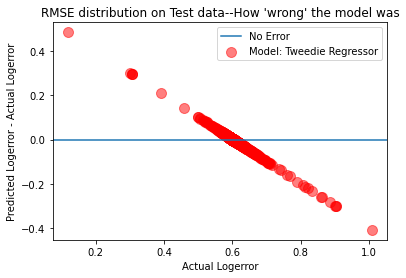

In [42]:
# A matplotlib scatterplot showing the residual error between predicted RMSE and actual tax value

plt.axhline(label="No Error")
plt.scatter(y_test_scaled.logerror, y_test_scaled.logerror_pred_glm_kbest - y_test_scaled.logerror,\
            alpha=.5, color="red", s=100, label="Model: Tweedie Regressor")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror - Actual Logerror")
plt.title("RMSE distribution on Test data--How 'wrong' the model was")
plt.show()

# CONCLUSIONS

## Summary:

At the beginning of my study, I took a few high-level type questions to get a handle on the problem, and refined them slowly with the time that was available:
   
- 
- 
- 
- 
    
Many of these questions had clear answers, but through statistical analysis I was able to make safe assumptions, which in turn led me down paths that I may have otherwise missed. _______________________

Even my model, which has room for improvement, was capable of predicting the logerror of home by over 1.5 percent on the test data, and with similar margins for the train and validate data. I expect it to perform as well on unseen data as well--keeping certain parameters constant.

## Recommendations

I recommend exploring _________
Additionally, running the model on LA county as separate from Ventura and Orange might see some benefit, seeing as there area some different ways that the features work on logerror there. Square feet per bathroom is an example here--it didn't make it into my model, but may have value for future models.  

## Next steps



The following is a brief list of items that I'd like to add to the model:

- 
- 
- 
- 
- 